# Logistic Regression Project

## Objective

The goal of this project is to build and evaluate logistic regression models to predict whether a team wins an NBA game (W/L) using game box score features. The project begins with a 1-feature baseline (points scored) and extends to a multivariate model using shooting and counting stats.


Collaborators: Suhas Makineni (author). Uses code but extends on a DSCI 322 project created by Andrew Muehleisen.

In [17]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import seaborn as sns
import sklearn
import sklearn.datasets
import sklearn.linear_model
import warnings

np.random.seed(42)
plt.style.use('fivethirtyeight')
sns.set()
sns.set_context("talk")

# Set some parameters
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 16
np.set_printoptions(4)

# We will use plot_3d helper function to help us visualize gradients
from nba_utils import plot_3d

%matplotlib inline

Load Data and create Binary targets. 

Target Definition:  $\hat{y} = P(Y = 1 | x)$, where $Y = 1$ 

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3
sns.set() 

In [19]:
df = pd.read_csv('nba.csv')
df["WON"] = df["WL"]
df["WON"] = df["WON"].replace("W", 1)
df["WON"] = df["WON"].replace("L", 0)
df.head(5)

/var/folders/9f/d35pg8xn0sxf3g91gtx60r4m0000gn/T/ipykernel_47981/2571168564.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["WON"] = df["WON"].replace("L", 0)


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,WON
0,22018,1610612744,GSW,Golden State Warriors,21800002,2018-10-16,GSW vs. OKC,W,240,42,...,58,28,7,7,21,29,108,8,1,1
1,22018,1610612760,OKC,Oklahoma City Thunder,21800002,2018-10-16,OKC @ GSW,L,240,33,...,45,21,12,6,15,21,100,-8,1,0
2,22018,1610612755,PHI,Philadelphia 76ers,21800001,2018-10-16,PHI @ BOS,L,240,34,...,47,18,8,5,16,20,87,-18,1,0
3,22018,1610612738,BOS,Boston Celtics,21800001,2018-10-16,BOS vs. PHI,W,240,42,...,55,21,7,5,15,20,105,18,1,1
4,22018,1610612750,MIN,Minnesota Timberwolves,21800010,2018-10-17,MIN @ SAS,L,240,39,...,46,20,9,2,11,27,108,-4,1,0


### Baseline: 1D Logistic Model Using Points Scored
Sigmoid and prediction function

In [20]:
def sigma(t):
    return 1 / (1 + np.exp(-t))
def predicted_probability_of_winning_given_pts(pts, theta):
    return sigma (pts * theta)

When using $\hat{y} = σ(θ⋅PTS)$, with no intercept, the curve is forced to be centered around 0 points. This produces unrealistic probabilities (ex. teams scoring very low amt of points will still receive win probabilities near or over 50% depending on θ.) θ only affects the slope, not the curves horizontal positioning. 

In [21]:
theta = 0.01
x = df["PTS"]
y_obs = df["WON"]
y_hat = predicted_probability_of_winning_given_pts(x, theta)

If we look at our predictions, we see that every team is given a greater than 50 percent prediction of winning based on their number of points. This suggests a problem with our model.

In [22]:
y_hat.mean()

np.float64(0.7517679619807067)

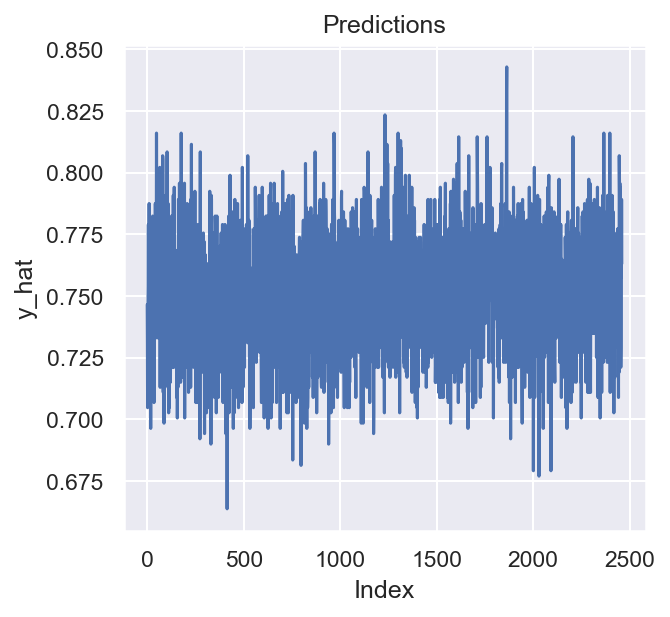

In [23]:
plt.plot(y_hat)
plt.xlabel("Index")
plt.ylabel("y_hat")
plt.title("Predictions");

To understand what's going on, I made a plot of the prediction our model which will be a function of the number of points scored for $\hat{\theta} = 0.01$. 

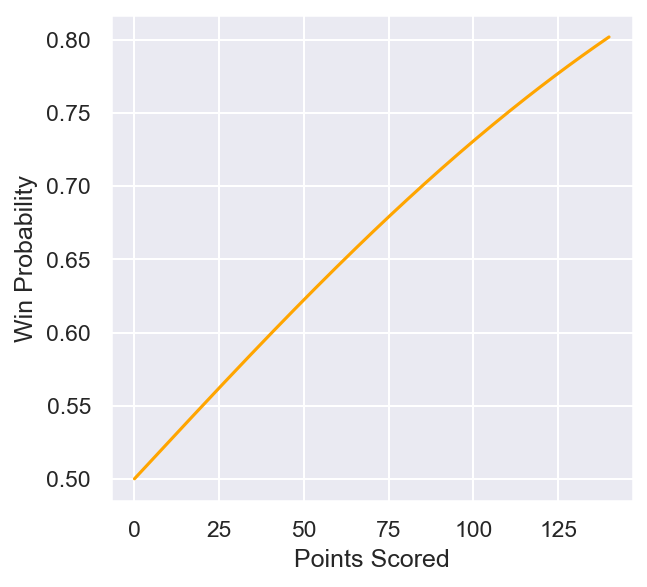

In [24]:
theta = 0.01
pts = np.linspace(0, 140, 140)
sns.lineplot(x = pts, y = predicted_probability_of_winning_given_pts(pts, theta), color = 'orange')
plt.ylabel("Win Probability")
plt.xlabel("Points Scored");

We can also provide the actual results from the NBA dataset as blue stars for comparison to our model.

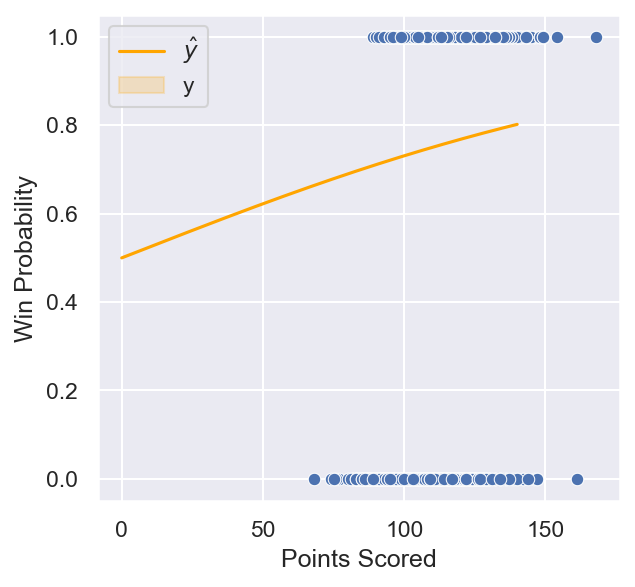

In [25]:
theta = 0.01
pts = np.linspace(0, 140, 140)
sns.lineplot(x = pts, y = predicted_probability_of_winning_given_pts(pts, theta), color = 'orange')
sns.scatterplot(x = df["PTS"], y = df["WON"])
plt.ylabel("Win Probability")
plt.xlabel("Points Scored")
plt.legend([r'$\hat{y}$', 'y']);

### Adding an intercept term

To make the model realistic, we add a constant feature equal to 1 for every observation:

In [26]:
points_and_bias = df[["PTS"]].copy()
points_and_bias["bias"] = 1
points_and_bias.head()

,PTS,bias
0,108,1
1,100,1
2,87,1
3,105,1
4,108,1


Now this model is : 

$\hat{y}=σ(θ1​⋅PTS+θ2​)$ 

In [27]:
def predicted_probability_of_winning_given_features(X, theta):
    X = np.array(X)
    theta = np.array(theta)
    linear = X.dot(theta)
    return sigma(linear)

This gives the model freedom to shift the curve left/right (via the intercept) and control steepness (via θ1).

In [28]:
theta = np.array([0.001, 2])
predicted_probability_of_winning_given_features(points_and_bias.iloc[0:3, :], theta)

array([0.8917, 0.8909, 0.8896])

In [29]:
points_and_bias.iloc[0:3, :]

,PTS,bias
0,108,1
1,100,1
2,87,1


Now that we have a bias term, we have more freedom to adjust our model.

For example, if $\theta_1 = 0.05$ and $\theta_2 = -5$, we get the curve below. Here, the prediction of your model is $\sigma(\theta_1 \times \text{PTS} + \theta_2)$. That is, $\theta_1$ is the weight of `PTS`, and $\theta_2$ is the weight of the bias term.

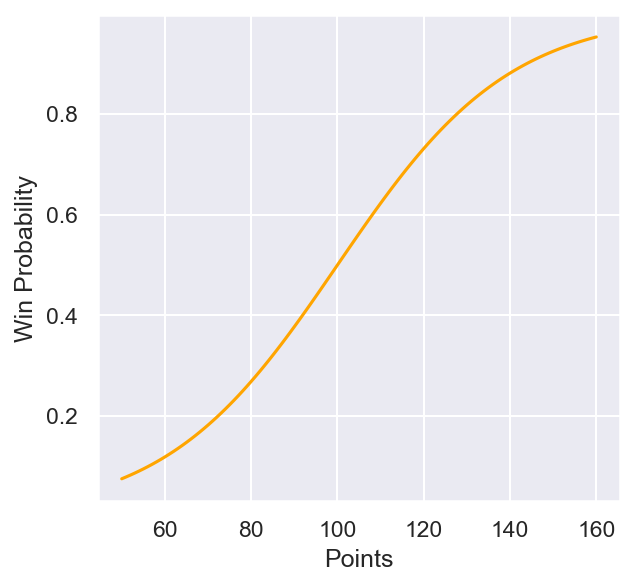

In [30]:
theta = [0.05, -5]
pts = np.linspace(50, 160, 111).reshape(-1, 1)
bias = np.ones(len(pts)).reshape(-1, 1)
point_range_and_bias = np.hstack((pts, bias))
probs = predicted_probability_of_winning_given_features(point_range_and_bias, theta)
plt.plot(pts, predicted_probability_of_winning_given_features(point_range_and_bias, theta), 'orange')
plt.ylabel("Win Probability")
plt.xlabel("Points");

And as before, we can also plot the actual data from our NBA dataset for comparison with our model.

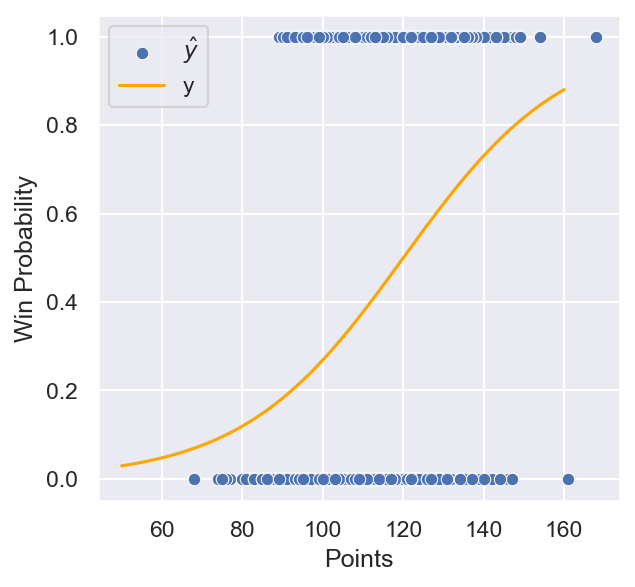

In [31]:
sns.scatterplot(x = df["PTS"], y = df["WON"])

theta = [0.05, -6
]
pts = np.linspace(50, 160, 111)
bias = np.ones(len(pts))
probs = predicted_probability_of_winning_given_features(point_range_and_bias, theta)

sns.lineplot(x = pts, y = probs, color = 'orange')
plt.ylabel("Win Probability")
plt.xlabel("Points")
plt.legend([r'$\hat{y}$', 'y']);

A larger theta seems to move the graph to the left indicating that there is a higher win probability at that total of points. Inversly, if we make theta smaller which lowers the win probability at a certail total of points. 

We now adjust $\theta_1$ and $\theta_2$ such that we get a sharp curve that is centered at 100 points. 

- By "centered at 100 points", we mean that $\hat{y}$ should be equal to 0.5 when $x = 100$.
- By "sharp", we mean that the probability should be less than 5% percent for $x = 80$, and greater than 95% for $x = 120$.


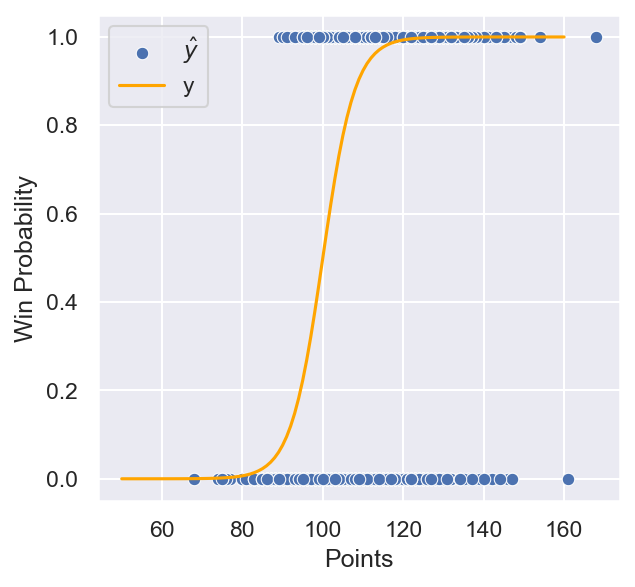

In [32]:
sns.scatterplot(x = df["PTS"], y = df["WON"])

theta = [0.25,-25]
pts = np.linspace(50, 160, 111)
bias = np.ones(len(pts))
probs = predicted_probability_of_winning_given_features(point_range_and_bias, theta)

sns.lineplot(x = pts, y = probs, color = 'orange')
plt.ylabel("Win Probability")
plt.xlabel("Points")
plt.legend([r'$\hat{y}$', 'y'])

### Training With MSE and why its harder to optimize


I now created a function `mse_for_model_on_NBA_data(theta)` that takes in a value of $\theta$ and returns the MSE on the dataset from above.

In [33]:
def mse(y_obs, y_hat):
    return np.mean((y_obs - y_hat) ** 2)

def mse_for_model_on_NBA_data(theta):
    theta = np.array(theta)
    y_hat = predicted_probability_of_winning_given_features(points_and_bias, theta)
    y_obs = df["WON"].values
    return mse(y_obs, y_hat)




The MSE loss surface for logistic regression often contains large flat regions, which makes optimization unstable and slow (small gradients over wide areas).

In [34]:
import plotly.graph_objects as go

num_points = 50 # increase for better resolution, but it will run more slowly. 

if (num_points <= 100):

    uvalues = np.linspace(-0.3, 0.3, num_points)
    vvalues = np.linspace(-20, 20, num_points)
    (u,v) = np.meshgrid(uvalues, vvalues)
    thetas = np.vstack((u.flatten(),v.flatten()))

    MSE = np.array([mse_for_model_on_NBA_data(t) for t in thetas.T])

    loss_surface = go.Surface(x=u, y=v, z=np.reshape(MSE, u.shape))

    fig = go.Figure(data=[loss_surface])
    fig.update_layout(scene = dict(
        xaxis_title = "theta0",
        yaxis_title = "theta1",
        zaxis_title = "MSE"))
    fig.show()
else:
    print("Picking num points > 100 can be really slow. If you really want to try, edit the code above so that this if statement doesn't trigger.")


Using `scipy.optimize.minimize` now we are trying find the optimal $\hat{\theta}$. 

In [35]:
from scipy.optimize import minimize

optimal_theta = minimize(
    mse_for_model_on_NBA_data,
    x0=[0.0, 0.0]
).x
theta_hat_1 = optimal_theta[0]
theta_hat_2 = optimal_theta[1]


Finally, let's try to understand how our model can be practically useful. As we'll see, we often convert our logistic regression models into a concrete prediction by thresholding. That is, if our $\hat{y} \geq 0.5$, we say our prediction is that the team will win; otherwise, we say that we predict that we will lose. A simple way to do this is just to round our $\hat{y}$.

In [36]:
y_hat = predicted_probability_of_winning_given_features(points_and_bias, np.array([theta_hat_1, theta_hat_2])) 
games_and_predictions = df.copy()
games_and_predictions["predicted_to_win"] = np.round(y_hat)
games_and_predictions[["TEAM_NAME", "GAME_DATE", "WON", "predicted_to_win"]].tail(5)

,TEAM_NAME,GAME_DATE,WON,predicted_to_win
2455,Denver Nuggets,2019-04-10,1,0.0
2456,Orlando Magic,2019-04-10,1,1.0
2457,Charlotte Hornets,2019-04-10,0,1.0
2458,Memphis Grizzlies,2019-04-10,1,1.0
2459,Golden State Warriors,2019-04-10,0,1.0


In [37]:
percentage_correct = np.mean(np.round(y_hat) == df["WON"].values)
percentage_correct

np.float64(0.7109756097560975)

### Switch to Cross-Entropy (Log Loss)

Cross-entropy is the standard objective for logistic regression and produces a smoother, better-behaved loss surface.

In [38]:
def cel(y_obs, y_hat):
    y_obs = np.array(y_obs)
    y_hat = np.array(y_hat)
    return -np.mean(y_obs * np.log(y_hat) + (1 - y_obs) * np.log(1 - y_hat))

def cel_for_model_on_NBA_data(theta):
    theta = np.array(theta)
    y_hat = predicted_probability_of_winning_given_features(points_and_bias, theta)
    y_obs = df["WON"].values
    return cel(y_obs, y_hat)




The cell below plots the cross-entropy loss function. Note that the surface has no big flat regions, which makes it easy to optimize.



In [39]:
import plotly.graph_objects as go
warnings.filterwarnings("ignore", category=RuntimeWarning)

num_points = 50 # increase for better resolution, but it will run more slowly. 

if (num_points <= 100):

    uvalues = np.linspace(-0.3, 0.3, num_points)
    vvalues = np.linspace(-20, 20, num_points)
    (u,v) = np.meshgrid(uvalues, vvalues)
    thetas = np.vstack((u.flatten(),v.flatten()))

    CEL = np.array([cel_for_model_on_NBA_data(t) for t in thetas.T])

    loss_surface = go.Surface(x=u, y=v, z=np.reshape(CEL, u.shape))

    fig = go.Figure(data=[loss_surface])
    fig.update_layout(scene = dict(
        xaxis_title = "theta0",
        yaxis_title = "theta1",
        zaxis_title = "CEL"))
    fig.show()
else:
    print("Picking num points > 100 can be really slow. If you really want to try, edit the code above so that this if statement doesn't trigger.")

### Turning Probabilities Into Predictions + Accuracy

To convert predicted win probabilities into a win/loss label, I apply a 0.5 decision threshold: games with \(\hat{y} \ge 0.5\) are predicted as wins, and games with ($\hat{y} < 0.5\$) are predicted as losses.


In [40]:
useful_numeric_fields = df.loc[:, 'FGM':'PTS'].copy()
useful_numeric_fields["BIAS"] = np.ones(len(useful_numeric_fields))
useful_numeric_fields.head(5)

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,BIAS
0,42,95,0.442,7,26,0.269,17,18,0.944,17,41,58,28,7,7,21,29,108,1.0
1,33,91,0.363,10,37,0.270,24,37,0.649,16,29,45,21,12,6,15,21,100,1.0
2,34,87,0.391,5,26,0.192,14,23,0.609,6,41,47,18,8,5,16,20,87,1.0
3,42,97,0.433,11,37,0.297,10,14,0.714,12,43,55,21,7,5,15,20,105,1.0
4,39,91,0.429,6,19,0.316,24,27,0.889,14,32,46,20,9,2,11,27,108,1.0


Multivariate Model (19 Features) and Leakage Control

I excluded PLUS_MINUS to prevent label leakage. Because PLUS_MINUS reflects the point differential, it effectively encodes the game outcome (positive if the team won, negative if it lost); including it would make the model near-perfect and not meaningful for prediction.

In [41]:
def mse_for_model_on_full_data(theta):
    theta = np.array(theta) 
    y_hat = sigma(useful_numeric_fields.values.dot(theta))
    y_obs = df["WON"].values
    return np.mean((y_obs - y_hat)**2)




theta_19_hat = minimize(
    mse_for_model_on_full_data,
    x0=np.zeros(useful_numeric_fields.shape[1])
).x

mse_for_model_on_full_data(theta_19_hat)


np.float64(0.1073659168322494)

In [42]:
probs = sigma(useful_numeric_fields.values.dot(theta_19_hat))
preds = np.round(probs)
frac_19_correct = np.mean(preds == df["WON"].values)
frac_19_correct

np.float64(0.8434959349593496)

Some coefficients may appear counterintuitive (for example, a negative coefficient on PTS) because many box-score variables are strongly correlated (multicollinearity). In a multivariate logistic regression, the model allocates shared predictive signal across correlated features, so individual coefficients represent conditional effects holding the others constant. As a result, coefficient signs and magnitudes can be unstable and should be interpreted cautiously unless you apply regularization and/or feature selection.

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define X (features) and y (target variable)
X_pts = df[["PTS"]]
y = df["WON"].astype(int)

# Full model: All fields from FGM to PTS, excluding PLUS_MINUS
X_full = df.loc[:, "FGM":"PTS"].copy()
if "PLUS_MINUS" in X_full.columns:
    X_full = X_full.drop(columns=["PLUS_MINUS"])

# Train-test split for both models

X_pts_train, X_pts_test, y_train, y_test = train_test_split(
    X_pts, y, test_size=0.20, random_state=42, stratify=y
)

X_full_train, X_full_test, _, _ = train_test_split(
    X_full, y, test_size=0.20, random_state=42, stratify=y
)

# Fit models with scaling for stability on multivariate model

# feature no scaler needed but doesn't hurt
baseline_model = LogisticRegression(max_iter=5000)
baseline_model.fit(X_pts_train, y_train)

# Full model: scale features + L2 regularization (default) to help multicollinearity
full_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=5000))
])
full_model.fit(X_full_train, y_train)

def evaluate(model, X_test, y_test, name="Model"):
    probs = model.predict_proba(X_test)[:, 1]
    preds = (probs >= 0.5).astype(int)
    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, probs)
    ll  = log_loss(y_test, probs)
    cm  = confusion_matrix(y_test, preds)

    print(f"\n{name}")
    print("-" * len(name))
    print(f"Test Accuracy: {acc:.4f}")
    print(f"ROC-AUC:       {auc:.4f}")
    print(f"Log Loss:      {ll:.4f}")
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_test, preds, digits=4))

evaluate(baseline_model, X_pts_test, y_test, name="Baseline (PTS only)")
evaluate(full_model, X_full_test, y_test, name="Full Model (FGM:PTS, no PLUS_MINUS)")




Baseline (PTS only)
-------------------
Test Accuracy: 0.6992
ROC-AUC:       0.7550
Log Loss:      0.5952
Confusion Matrix:
 [[177  69]
 [ 79 167]]

Classification Report:
               precision    recall  f1-score   support

           0     0.6914    0.7195    0.7052       246
           1     0.7076    0.6789    0.6929       246

    accuracy                         0.6992       492
   macro avg     0.6995    0.6992    0.6991       492
weighted avg     0.6995    0.6992    0.6991       492


Full Model (FGM:PTS, no PLUS_MINUS)
-----------------------------------
Test Accuracy: 0.8577
ROC-AUC:       0.9298
Log Loss:      0.3397
Confusion Matrix:
 [[207  39]
 [ 31 215]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8697    0.8415    0.8554       246
           1     0.8465    0.8740    0.8600       246

    accuracy                         0.8577       492
   macro avg     0.8581    0.8577    0.8577       492
weighted avg     0.85

### Train/Test Evaluation (80/20 split, stratified sampling)


To assess generalization, I evaluated each model using an 80/20 train/test split with stratification to preserve the win/loss class balance.

### Baseline: PTS-only Logistic Regression
- **Test Accuracy:** 0.6992  
- **ROC-AUC:** 0.7550  
- **Log Loss:** 0.5952  
- **Confusion Matrix:** \(\begin{bmatrix}177 & 69\\79 & 167\end{bmatrix}\)

This baseline captures a meaningful signal (teams that score more tend to win), but points alone omit important game context.

### Full Model: Box-Score Features (FGM:PTS), excluding `PLUS_MINUS`
- **Test Accuracy:** 0.8577  
- **ROC-AUC:** 0.9298  

The multivariate model substantially outperforms the baseline, showing that combining shooting and counting stats produces a far more discriminative win-probability model. Excluding `PLUS_MINUS` prevents label leakage since it effectively encodes the outcome.

### Improvement Over Baseline
- Accuracy improved from **0.6992 → 0.8577** (**+0.1585**, or **+15.85 percentage points**)  
- ROC-AUC improved from **0.7550 → 0.9298** (**+0.1748**)

### Notes on Coefficient Interpretation
Some coefficient signs may appear counterintuitive due to **multicollinearity** among strongly correlated box-score features (e.g., PTS, FGM, FGA, FG%). In multivariate logistic regression, coefficients represent *conditional* effects holding other predictors constant; with correlated predictors, individual coefficients are less directly interpretable even when predictive performance is strong. Using **feature scaling** and **L2 regularization** helps stabilize the solution and improves robustness.


